In [52]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict, set_size
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ['api_only_full', 'api_only_name', 'file', 'network', 'registry', 'full', 'all']
RUN_NAME = "fields"

INFOLDER = "out_fields_whitespace_granular"
RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]
LIMIT = "full"

VOCAB = 50000
SEQ_LEN = 512

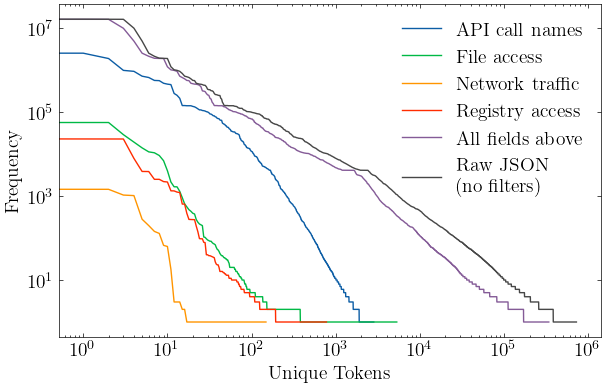

In [71]:
counters = {}
import scienceplots
plt.style.use(['science'])#,'no-latex'])
# revert to default plt style
#plt.style.use('default')
fontsize = 14

fig, ax = plt.subplots(1,1, figsize=set_size())

for run_type in RUN_TYPES:
    if run_type in ["api_only_full"]:
        # for some reason "api_only_full" has practically the same token counts as "full"
        # it might be related to pre-processing that strips all the punctuation?
        # i.e. text = text.translate(str.maketrans('', '', string.punctuation))
        continue
    counter_file = os.path.join(INFOLDER, f"{run_type}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_counter.json")
    with open(counter_file) as f:
        counter = json.load(f)
    # sort by value
    counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1], reverse=True)}
    counters[run_type] = counter

    # rename labels
    if run_type == "all":
        run_type = "Raw JSON\n(no filters)"
    elif run_type == "api_only_name":
        run_type = "API call names"
    elif run_type == "file":
        run_type = "File access"
    elif run_type == "network":
        run_type = "Network traffic"
    elif run_type == "registry":
        run_type = "Registry access"
    elif run_type == "full":
        run_type = "All fields above"

    # plot all token counts
    ax.plot(list(counter.values()), label=run_type)
ax.set_yscale("log")
ax.set_xscale("log")
# scale all ticks
#ax.grid(True, which="both")
ax.set_ylabel("Frequency")
ax.set_xlabel("Unique Tokens")

# increase font size for all text
ax.tick_params(labelsize=fontsize)
ax.xaxis.label.set_size(fontsize)
ax.yaxis.label.set_size(fontsize)
# # set xticks on 10^1, 10^2, 10^3, 10^4, 10^5
# ax.set_xticks([10**x for x in range(0, 6)])

_ = ax.legend(fontsize=fontsize, loc="upper right")# center", bbox_to_anchor=(0.5, 1.35), ncol=3)
#_ = ax.legend(fontsize=fontsize, loc="upper center", bbox_to_anchor=(0.5, 1.35), ncol=3)
# save 
plt.savefig(os.path.join(REPO_ROOT, "img", f"token_counts_{RUN_NAME}.pdf"), dpi=300, format="pdf", bbox_inches="tight")

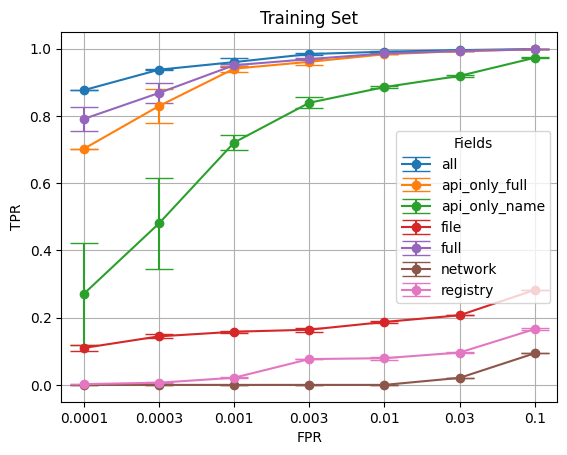

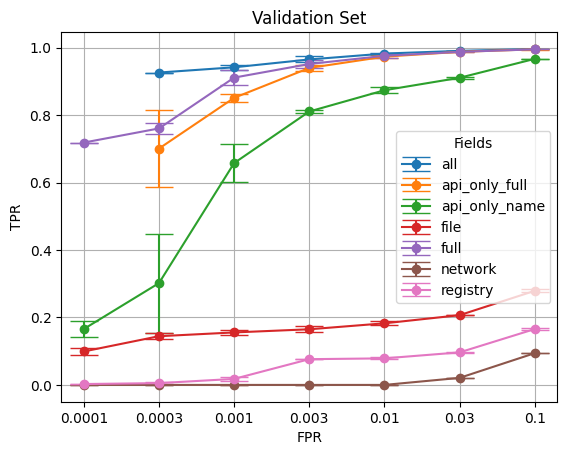

In [17]:
plt.style.use('default')

def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[:-2]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [18]:
models = defaultdict(dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for run_type in RUN_TYPES:
    nebula_vocab_file = os.path.join(INFOLDER, f"{run_type}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_vocab.json")

    with open(nebula_vocab_file) as f:
        nebula_vocab = json.load(f)
    models[run_type]['class'] = TransformerEncoderChunks
    models[run_type]['config'] = {
        "vocab_size": len(nebula_vocab),
        "maxlen": SEQ_LEN,
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True
    }

In [19]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = '_'.join(folder.split("_")[1:-3])
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")

        folder = os.path.join(INFOLDER, folder)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_val)

,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
all,0.702971,0.843331,0.928059,0.966640,0.982279,0.990439,0.996263,0.999420,0.998514,0.989938,0.987266,0.992629,0.985554
api_only_full,0.454023,0.615207,0.853378,0.936548,0.972462,0.987387,0.995200,0.998989,0.997776,0.986699,0.986123,0.987277,0.982030
api_only_name,0.212519,0.373453,0.658255,0.810874,0.875462,0.909797,0.967140,0.998445,0.989757,0.955634,0.941759,0.970070,0.940940
file,0.096402,0.142475,0.154172,0.164715,0.182272,0.210183,0.283766,0.501020,0.681960,0.866606,0.992359,0.769141,0.780122
full,0.578514,0.700004,0.882963,0.951311,0.975296,0.987367,0.994752,0.998970,0.997884,0.986968,0.986395,0.987564,0.982385
network,0.000176,0.000405,0.001208,0.003501,0.011447,0.032468,0.103811,0.295978,0.499068,0.837028,1.000000,0.719735,0.719735
registry,0.003013,0.009028,0.020943,0.076447,0.083212,0.102025,0.168417,0.360879,0.556607,0.839583,0.993387,0.727028,0.726805


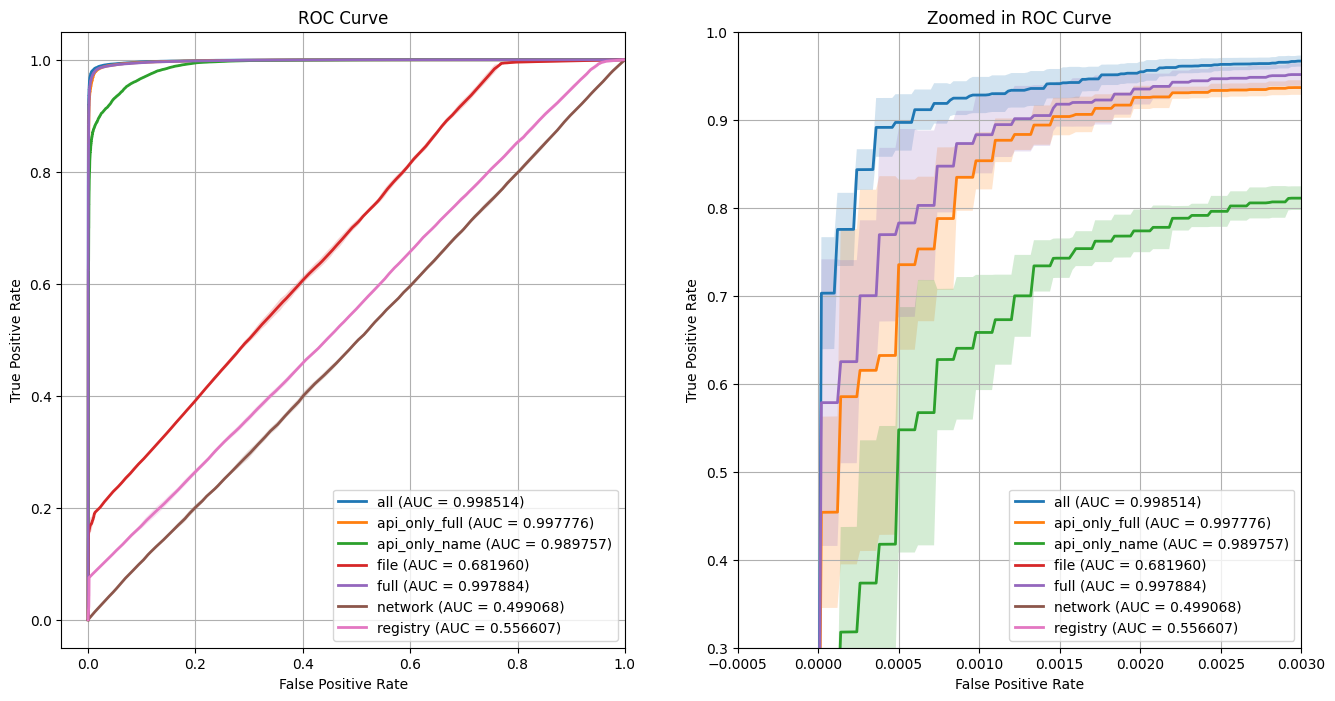

In [20]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val,
    tprs_std_val,
    metrics_val,
    xlim=[-0.0005, 0.003],
    ylim=[0.3, 1.0],
    metrics_full=True
)
df

## Test set ROCs

In [21]:
model_files = defaultdict(list)
metrics_test = defaultdict(list)
for folder in run_folders:
    key = '_'.join(folder.split("_")[1:-3])
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if str(key) in x and not f"_{key}" in x and "vocab" in x][0]
        print(f"[*] In process: {key} | Using folder: {data_folder}")
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=64
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
all,0.002340,0.007232,0.017477,0.043532,0.109433,0.227410,0.533447,0.747904,0.788599,0.727456,0.694317,0.766128,0.722257
api_only_full,0.121997,0.246730,0.418838,0.578220,0.706406,0.823212,0.892162,0.941331,0.952758,0.895899,0.838172,0.962480,0.894946
api_only_name,0.046297,0.072750,0.100624,0.147612,0.192752,0.265093,0.396489,0.569745,0.690785,0.326794,0.204474,0.944194,0.561728
file,0.024602,0.028407,0.039127,0.043680,0.051750,0.072968,0.148113,0.371224,0.542677,0.640650,0.832004,0.531879,0.517206
full,0.297813,0.368748,0.515616,0.686518,0.800277,0.860541,0.911766,0.953915,0.966321,0.906041,0.853167,0.966813,0.904579
network,0.000695,0.001425,0.002404,0.004162,0.009191,0.028950,0.089404,0.255341,0.470233,0.699110,0.991882,0.539805,0.538845
registry,0.000674,0.007763,0.020370,0.027352,0.038552,0.062716,0.148865,0.354784,0.544887,0.687231,0.947038,0.539807,0.535532


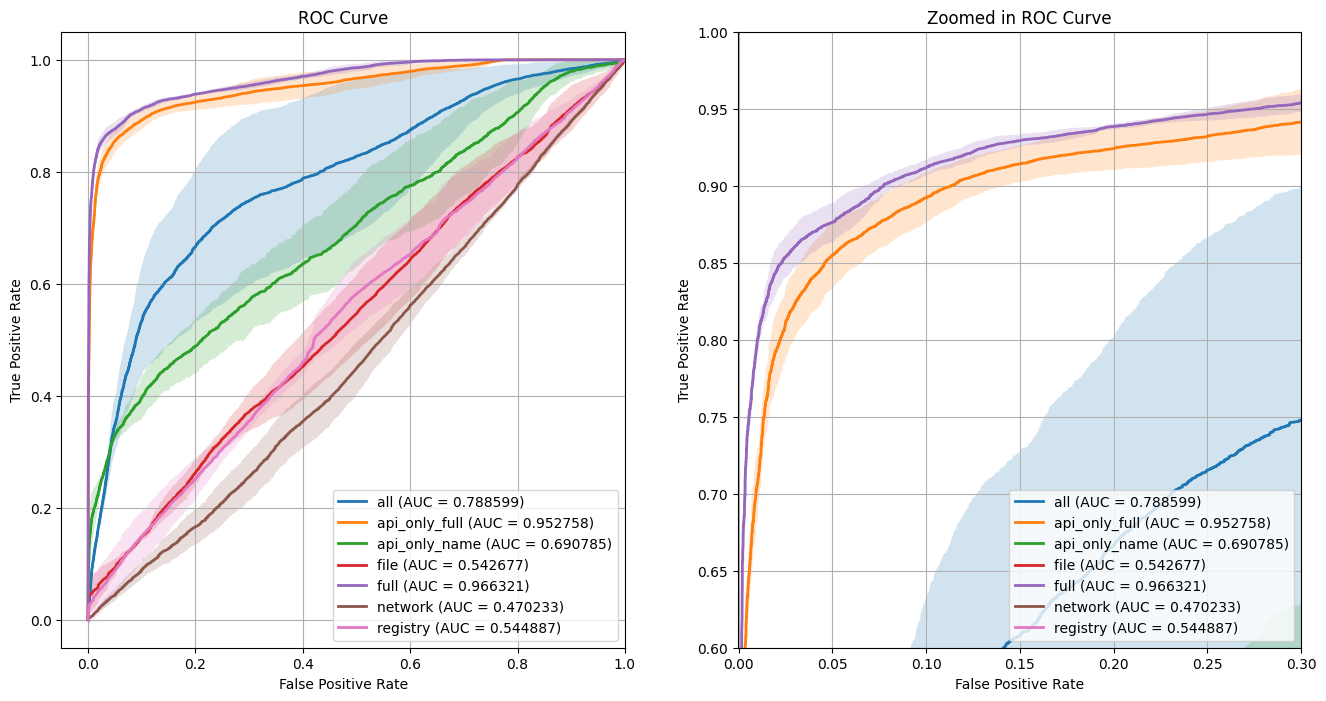

In [22]:
base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_test)

df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test,
    tprs_std_test,
    metrics_test,
    metrics_full=True
)
df

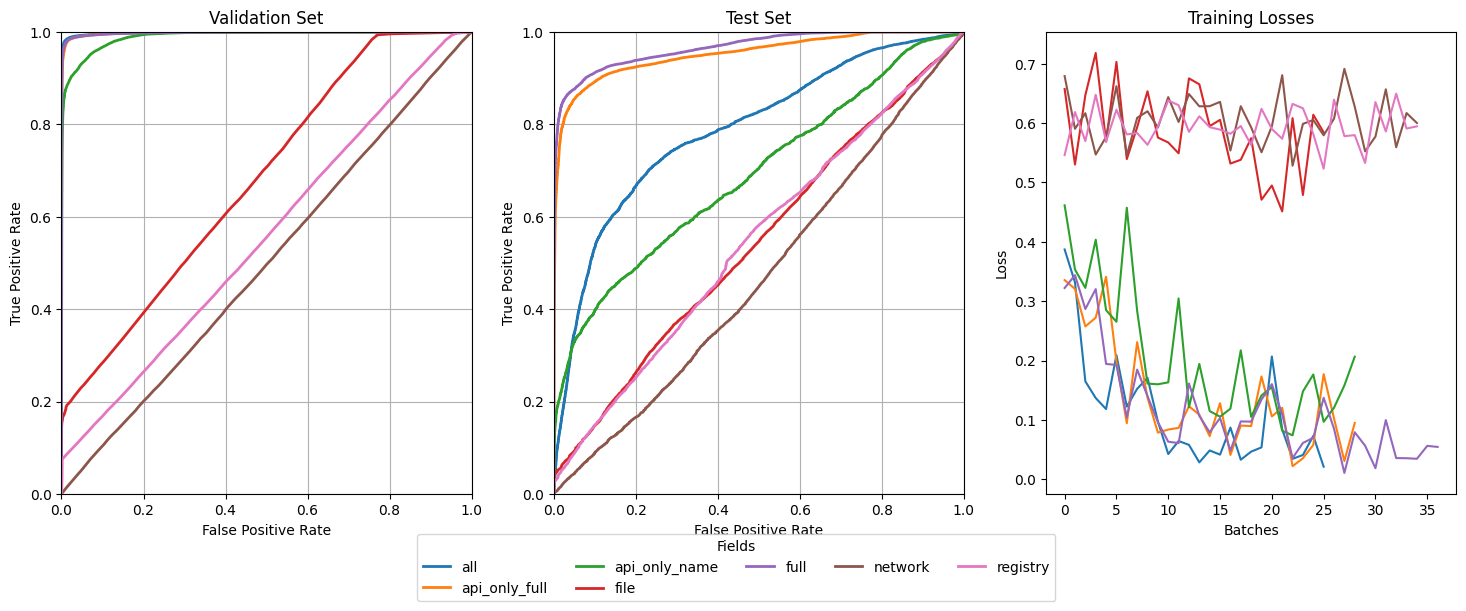

In [23]:
YLIM = [0, 1]
XLIM = [-0.0005, 1]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 'file_network_registry': # erros out for some reason, but do not care about that really
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

start = 100
n = 70
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]    
    axs[2].plot(loss_mean, label=key)
axs[2].set_xlabel("Batches")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')

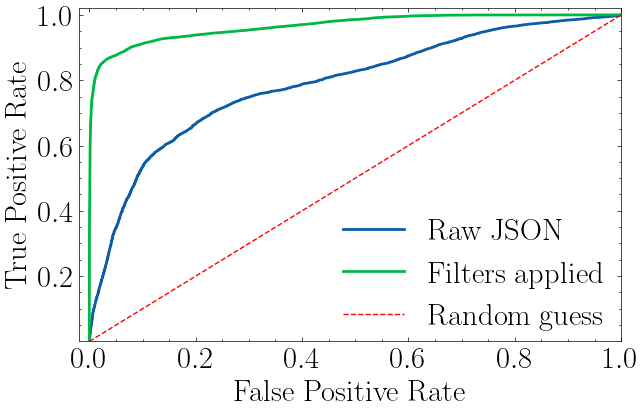

In [50]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
# use default style
#plt.style.use('default')
fontsize = 22
XLIM = [-0.02, 1]
YLIM = [0, 1.02]

# force reload function
from importlib import reload
import nebula.misc.plots as plots
reload(plots)
from nebula.misc.plots import plot_roc_curve, set_size

fig, axs = plt.subplots(1, 1, figsize=set_size())

labels = ['all', 'full']
tprs_mean_val_slice = {k: v for k, v in tprs_mean_val.items() if k in labels}
tprs_std_val_slice = {k: v for k, v in tprs_std_val.items() if k in labels}
tprs_mean_test_slice = {k: v for k, v in tprs_mean_test.items() if k in labels}
tprs_std_test_slice = {k: v for k, v in tprs_std_test.items() if k in labels}
for i, key in enumerate(tprs_mean_val_slice.keys()):
    # plot_roc_curve(
    #     base_fpr_val, 
    #     tprs_mean_val_slice[key], 
    #     #tprs_std_val_slice[key], 
    #     model_name=key, 
    #     ax=axs, 
    #     ylim=YLIM, 
    #     xlim=XLIM,
    #     color=colors[i]
    # )
    plot_roc_curve(
        base_fpr_test,
        tprs_mean_test_slice[key], 
        #tprs_std_test_slice[key], 
        model_name=key, 
        ax=axs, 
        ylim=YLIM, 
        xlim=XLIM, 
        linestyle="-",
        #color=colors[i]
    )

ax.set_title("ROC Curves")
axs.set_ylabel("True Positive Rate")
axs.set_xlabel("False Positive Rate")

# plot random guess line
axs.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess', linewidth=1)
# get handles and labels for legend
handles, labels = axs.get_legend_handles_labels() 
# place legend outside of plot on top middle
#axs.legend(handles, ["No filters (raw JSON)", "Filters applied", "Random guess"], bbox_to_anchor=(0.5, 1.12), loc='upper center', ncol=3, fontsize=fontsize)
# swap first and 2nd element in legend
axs.legend(handles, ["Raw JSON", "Filters applied", "Random guess"], fontsize=fontsize, loc='lower right', bbox_to_anchor=(1.02, -0.05), ncol=1)

# increase font size for all text
axs.tick_params(labelsize=fontsize)
axs.xaxis.label.set_size(fontsize)
axs.yaxis.label.set_size(fontsize)

axs.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])

# savefig
_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_filters_vs_no_filters.pdf"), dpi=300, bbox_inches='tight')